<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Library" data-toc-modified-id="Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Library</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#LSTM_FI_top15_rank.csv" data-toc-modified-id="LSTM_FI_top15_rank.csv-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LSTM_FI_top15_rank.csv</a></span></li><li><span><a href="#MEAN_top15_rank.csv" data-toc-modified-id="MEAN_top15_rank.csv-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MEAN_top15_rank.csv</a></span><ul class="toc-item"><li><span><a href="#Revised-version-230312" data-toc-modified-id="Revised-version-230312-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Revised version 230312</a></span></li></ul></li><li><span><a href="#MEAN_top_n개" data-toc-modified-id="MEAN_top_n개-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>MEAN_top_n개</a></span></li><li><span><a href="#Correlation-Dendrogram" data-toc-modified-id="Correlation-Dendrogram-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Correlation Dendrogram</a></span><ul class="toc-item"><li><span><a href="#Revised-version-230313" data-toc-modified-id="Revised-version-230313-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Revised version 230313</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualization</a></span></li></ul></div>

# Library

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(42)

from typing import List, Set, Dict, Tuple, Optional, Any
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
import shap
shap.initjs()

print('tf:', tf.__version__)
print('shap:', shap.__version__)

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import mean_squared_error as mse

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.inspection import permutation_importance
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
       style='white')

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        print(e)

tf: 2.5.0
shap: 0.41.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data 
- Add information for each feature to the df ('28_score.csv') that contains 28 scores

In [3]:
# 1. Create feature_df containing information for 3595 features
mimic_path = '/data/MIMIC_III/'
lab = pd.read_csv(mimic_path + 'D_LABITEMS.csv')
pro = pd.read_csv(mimic_path + 'D_ITEMS.csv')
pre = pd.read_csv(mimic_path + 'PRESCRIPTIONS.csv')

df = pd.read_csv('total_data.csv')
score = pd.read_csv('28_score.csv')
df = df[df['ITEMID'].isin(score['feature'])]

LAB_list = df[df['TYPE']=='LAB']['ITEMID'].unique()
PRO_list = df[df['TYPE']=='PRO']['ITEMID'].unique()
PRE_list = df[df['TYPE']=='PRE']['ITEMID'].unique()

result = []
for i in LAB_list:
    result.append({'feature':i, 'feature_name':lab[lab['ITEMID']==i]['LABEL'].unique()[0], 'type':'LAB'})
for i in PRE_list:
    result.append({'feature':i, 'feature_name':pre[pre['NDC']==i]['DRUG'].unique()[0], 'type':'PRE'})
for i in PRO_list:
    result.append({'feature':i, 'feature_name':pro[pro['ITEMID']==i]['LABEL'].unique()[0], 'type':'PRO'})

feature_df = pd.DataFrame(result).sort_values(by = 'feature', ascending = True).reset_index(drop = True)
feature_df

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.


,feature,feature_name,type
0,0,D5W,PRE
1,50803,"Calculated Bicarbonate, Whole Blood",LAB
2,50804,Calculated Total CO2,LAB
3,50805,Carboxyhemoglobin,LAB
4,50806,"Chloride, Whole Blood",LAB
...,...,...,...
3590,74312001370,Cyanocobalamin,PRE
3591,78112001103,Chloraseptic Throat Spray,PRE
3592,87701071218,Cyanocobalamin,PRE
3593,87701083336,Diphenhydramine HCl,PRE


In [4]:
# 2. Merge the df containing 28 scores with feature_df
score_df = pd.concat([feature_df, score.iloc[:,1:]], axis = 1)
score_df

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,LSTM_per,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap
0,0,D5W,PRE,0.020509,0.034053,0.034465,0.004157,0.02,0.001659,0.006075,0.004310,12,0.328759,0.000549,0.002109,0.003842,-1.222021e-03,0.002146,0.001600,0.002387,0.001307,0.002736,0.004067,0.003701,0.011072,0.000827,0.003010,0.01823,0.033981,0.036032,0.025929
1,50803,"Calculated Bicarbonate, Whole Blood",LAB,0.000668,0.000136,0.000108,0.000540,0.00,0.000827,0.000000,0.001867,1,0.018038,0.000019,0.000108,0.000000,8.889650e-05,0.000000,-0.000246,-0.000051,-0.000003,0.000093,0.000114,0.000107,0.000267,0.000000,0.000577,0.00000,0.007018,0.001612,0.001147
2,50804,Calculated Total CO2,LAB,0.017698,0.009328,0.016669,0.001322,0.00,0.003035,0.000000,0.000669,8,0.140217,0.000424,0.000271,0.000000,1.915554e-03,0.000000,0.000352,0.000421,0.000243,0.000322,0.000650,0.000453,0.001751,0.000000,0.006886,0.00000,0.008793,0.008047,0.005351
3,50805,Carboxyhemoglobin,LAB,0.000009,0.000023,0.000025,0.000000,0.00,0.000009,0.000000,0.000000,0,0.000000,-0.000003,0.000000,0.000000,3.492986e-07,0.000000,0.000000,0.000000,0.000000,0.000002,0.000002,0.000001,0.000000,0.000000,0.000004,0.00000,0.000000,0.000000,0.000000
4,50806,"Chloride, Whole Blood",LAB,0.002298,0.001759,0.001661,0.000000,0.00,0.001735,0.000000,0.001767,12,0.259910,-0.000098,0.000000,0.000000,5.833287e-05,0.000000,0.000767,0.001036,0.000001,0.000050,0.000147,0.000070,0.000248,0.000000,0.001873,0.00000,0.020701,0.018778,0.010395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,74312001370,Cyanocobalamin,PRE,0.000153,0.000155,0.000204,0.000000,0.00,0.000000,0.000000,0.000000,0,0.000000,-0.000039,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000003,0.000006,0.000004,0.000000,0.000000,0.000001,0.00000,0.000000,0.000000,0.000000
3591,78112001103,Chloraseptic Throat Spray,PRE,0.000347,0.000608,0.000595,0.001467,0.00,0.000484,0.000539,0.001953,6,0.065610,-0.000076,0.000378,0.000000,1.708070e-04,0.000341,0.000321,0.000874,0.000436,0.000202,0.000153,0.000183,0.001400,0.000000,0.000556,0.00181,0.005992,0.006846,0.003147
3592,87701071218,Cyanocobalamin,PRE,0.001097,0.001453,0.001904,0.000957,0.00,0.000341,0.000000,0.000000,0,0.000000,-0.000126,0.000000,0.000000,-3.143687e-05,0.000000,0.000000,0.000000,0.000000,0.000237,0.000241,0.000202,0.000000,0.000000,0.000090,0.00000,0.000000,0.000000,0.000000
3593,87701083336,Diphenhydramine HCl,PRE,0.000068,0.000090,0.000097,0.000327,0.00,0.000086,0.000000,0.000000,0,0.000000,0.000004,0.000108,0.000000,-1.886212e-05,0.000000,0.000000,0.000000,0.000000,0.000023,0.000029,0.000027,0.000081,0.000000,0.000016,0.00000,0.000000,0.000000,0.000000


# LSTM_FI_top15_rank.csv
- Rank based on top 15 of LSTM simulation

In [5]:
rank_df = score_df.iloc[:,3:].rank(ascending = False)
score_rank_df = pd.concat([score_df.iloc[:,:3], rank_df], axis = 1)
score_rank_df

# score_rank_df.to_csv('score_rank_df.csv', index = False)

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,LSTM_per,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap
0,0,D5W,PRE,17.0,10.0,9.0,33.0,25.5,141.0,32.0,20.0,44.0,63.0,11.0,23.0,13.0,3592.0,16.0,20.0,11.0,18.0,5.0,3.0,3.0,30.0,18.0,88.0,31.0,43.0,32.0,38.0
1,50803,"Calculated Bicarbonate, Whole Blood",LAB,656.0,1526.0,1652.0,560.5,1822.5,331.0,1947.5,155.0,557.5,540.0,443.5,221.5,1819.0,318.0,1844.5,3519.0,3457.0,3270.0,505.0,439.0,457.0,437.0,1822.5,361.0,1949.0,234.0,458.0,389.0
2,50804,Calculated Total CO2,LAB,26.0,93.0,38.0,195.0,1822.5,37.0,1947.5,553.0,102.5,153.0,16.0,154.5,1819.0,11.0,1844.5,124.0,103.0,109.0,180.0,84.0,123.0,202.0,1822.5,28.0,1949.0,205.0,172.0,160.0
3,50805,Carboxyhemoglobin,LAB,2704.0,2455.0,2413.0,2110.5,1822.5,2630.0,1947.5,2116.5,2117.5,2323.5,2456.0,1852.0,1819.0,973.5,1844.5,1879.0,1905.5,1899.0,2420.0,2394.0,2553.0,2103.5,1822.5,2090.0,1949.0,2116.5,2117.5,2323.5
4,50806,"Chloride, Whole Blood",LAB,289.0,426.0,456.0,2110.5,1822.5,128.0,1947.5,185.0,44.0,85.0,3311.5,1852.0,1819.0,402.0,1844.5,61.0,33.0,564.0,744.0,366.0,611.0,451.0,1822.5,141.0,1949.0,97.0,73.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,74312001370,Cyanocobalamin,PRE,1273.0,1454.0,1315.0,2110.5,1822.5,3321.5,1947.5,2116.5,2117.5,2323.5,3107.5,1852.0,1819.0,1873.5,1844.5,1879.0,1905.5,1899.0,2244.0,1792.0,2024.0,2103.5,1822.5,2593.0,1949.0,2116.5,2117.5,2323.5
3591,78112001103,Chloraseptic Throat Spray,PRE,902.0,819.0,825.0,174.0,1822.5,542.0,189.0,136.0,170.5,291.0,3264.0,133.0,1819.0,210.0,64.0,137.0,41.0,67.0,273.0,351.0,294.0,229.0,1822.5,370.0,125.0,262.0,201.0,219.0
3592,87701071218,Cyanocobalamin,PRE,473.0,491.0,419.0,304.0,1822.5,679.0,1947.5,2116.5,2117.5,2323.5,3357.0,1852.0,1819.0,3192.0,1844.5,1879.0,1905.5,1899.0,240.0,256.0,273.0,2103.5,1822.5,956.0,1949.0,2116.5,2117.5,2323.5
3593,87701083336,Diphenhydramine HCl,PRE,1701.0,1768.0,1702.0,606.0,1822.5,1416.0,1947.5,2116.5,2117.5,2323.5,733.5,221.5,1819.0,3070.5,1844.5,1879.0,1905.5,1899.0,1105.0,1005.0,994.0,575.0,1822.5,1515.0,1949.0,2116.5,2117.5,2323.5


In [5]:
LSTM_FI = score_df[['feature', 'LSTM_FI']].sort_values(by = 'LSTM_FI', ascending = False)
LSTM_top15_idx = list(LSTM_FI['feature'][:15])
LSTM_FI_top15 = score_rank_df[score_rank_df['feature'].isin(LSTM_top15_idx)].sort_values(by = 'LSTM_FI')
LSTM_FI_top15

# LSTM_FI_top15.to_csv('LSTM_FI_top15_rank.csv', index = False)

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,LSTM_per,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap
190,51277,RDW,LAB,1.0,1.0,1.0,1.0,25.5,1.0,1.0,1.0,5.5,2.0,3594.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
110,51006,Urea Nitrogen,LAB,2.0,2.0,2.0,3.0,1.0,2.0,3.0,5.0,16.0,6.0,3595.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,1.0,2.0,2.0,4.0,5.0,3.0,4.0,6.0,6.0,4.0
52,50912,Creatinine,LAB,3.0,3.0,3.0,4.0,25.5,3.0,5.0,19.0,8.0,7.0,3590.0,3.0,28.0,12.0,12.0,8.0,72.0,71.0,6.0,6.0,6.0,3.0,10.0,2.0,3.0,4.0,4.0,3.0
3392,63323026201,Heparin,PRE,4.0,4.0,4.0,2.0,25.5,4.0,2.0,2.0,8.0,3.0,3593.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,5.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0
38,50893,"Calcium, Total",LAB,6.0,5.0,10.0,349.0,1822.5,26.0,263.0,574.0,81.0,179.0,3591.0,112.5,1819.0,3586.0,1844.5,336.0,170.0,3533.0,9.0,11.0,11.0,191.0,1822.5,73.0,1949.0,313.0,248.0,213.0
1929,409176230,Morphine Sulfate,PRE,8.0,6.0,6.0,28.0,1822.5,44.0,53.0,86.0,29.0,29.0,3589.0,73.0,1819.0,2922.0,30.0,21.0,47.0,37.0,48.0,27.0,56.0,65.0,1822.5,24.0,20.0,18.0,16.0,20.0
31,50882,Bicarbonate,LAB,5.0,7.0,5.0,15.0,1822.5,11.0,28.0,206.0,18.0,21.0,3592.0,7.0,1819.0,46.0,3585.0,3575.0,243.0,3536.0,12.0,10.0,17.0,10.0,1822.5,13.0,16.0,16.0,23.0,16.0
18,50861,Alanine Aminotransferase (ALT),LAB,21.0,8.0,7.0,83.0,25.5,42.0,56.0,213.0,44.0,24.0,3476.0,3449.0,29.0,15.0,21.0,36.0,20.0,14.0,10.0,12.0,9.0,201.0,15.0,67.0,24.0,23.0,22.0,19.0
559,8084199,Pantoprazole,PRE,15.0,9.0,12.0,14.0,1822.5,54.0,76.0,172.0,20.5,31.0,2.0,3595.0,1819.0,40.0,70.0,82.0,24.0,40.0,11.0,9.0,10.0,11.0,1822.5,99.0,59.0,32.0,28.0,34.0
0,0,D5W,PRE,17.0,10.0,9.0,33.0,25.5,141.0,32.0,20.0,44.0,63.0,11.0,23.0,13.0,3592.0,16.0,20.0,11.0,18.0,5.0,3.0,3.0,30.0,18.0,88.0,31.0,43.0,32.0,38.0


# MEAN_top15_rank.csv 
- Top 15 average of 28 methodologies for 3595 items

In [5]:
rank_df = score_df.iloc[:,3:].rank(ascending = False)
score_rank_df = pd.concat([score_df.iloc[:,:3], rank_df], axis = 1)
score_rank_df['rank_mean'] = score_rank_df.iloc[:,3:].mean(axis = 1)
score_rank_df = score_rank_df.sort_values(by = 'rank_mean', ascending = True)

MEAN_top15_idx = list(score_rank_df['feature'][:15])
MEAN_top15 = score_rank_df[score_rank_df['feature'].isin(MEAN_top15_idx)]
MEAN_top15

# MEAN_top15.to_csv('MEAN_top15_rank.csv', index = False)

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,LSTM_per,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap,rank_mean
190,51277,RDW,LAB,1.0,1.0,1.0,1.0,25.5,1.0,1.0,1.0,5.5,2.0,3594.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,130.821429
3392,63323026201,Heparin,PRE,4.0,4.0,4.0,2.0,25.5,4.0,2.0,2.0,8.0,3.0,3593.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,5.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0,132.089286
110,51006,Urea Nitrogen,LAB,2.0,2.0,2.0,3.0,1.0,2.0,3.0,5.0,16.0,6.0,3595.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,1.0,2.0,2.0,4.0,5.0,3.0,4.0,6.0,6.0,4.0,132.357143
52,50912,Creatinine,LAB,3.0,3.0,3.0,4.0,25.5,3.0,5.0,19.0,8.0,7.0,3590.0,3.0,28.0,12.0,12.0,8.0,72.0,71.0,6.0,6.0,6.0,3.0,10.0,2.0,3.0,4.0,4.0,3.0,140.125000
19,50862,Albumin,LAB,34.0,16.0,16.0,7.0,25.5,5.0,13.0,92.0,13.0,10.0,3555.0,65.0,9.0,5.0,15.0,28.0,7.0,12.0,8.0,8.0,8.0,13.0,11.0,6.0,11.0,8.0,8.0,8.0,143.446429
108,51003,Troponin T,LAB,19.0,15.0,15.0,6.0,25.5,8.0,7.0,84.0,11.0,11.0,3383.0,10.0,11.0,9.0,18.0,34.0,45.0,65.0,160.0,129.0,87.0,6.0,3.0,5.0,7.0,9.0,9.0,7.0,149.946429
1975,409606211,Morphine Sulfate,PRE,113.0,82.0,85.0,5.0,25.5,14.0,4.0,3.0,1.0,1.0,3568.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,108.0,106.0,98.0,12.0,6.0,16.0,5.0,2.0,2.0,5.0,152.589286
0,0,D5W,PRE,17.0,10.0,9.0,33.0,25.5,141.0,32.0,20.0,44.0,63.0,11.0,23.0,13.0,3592.0,16.0,20.0,11.0,18.0,5.0,3.0,3.0,30.0,18.0,88.0,31.0,43.0,32.0,38.0,156.767857
885,54817525,Dexamethasone,PRE,465.0,416.0,477.0,285.0,25.5,422.0,25.0,55.0,20.5,26.0,52.0,185.5,16.0,131.0,11.0,17.0,13.0,9.0,342.0,311.0,333.0,259.0,41.0,293.0,39.0,60.0,54.0,43.0,158.089286
1700,245004101,Potassium Chloride,PRE,110.0,132.0,116.0,47.0,25.5,25.0,8.0,8.0,13.0,13.0,3551.0,41.0,6.0,23.0,8.0,13.0,9.0,7.0,85.0,143.0,86.0,33.0,8.0,23.0,10.0,11.0,12.0,11.0,163.482143


## Revised version 230312
1. Add a column for average ranking
2. Remove per_LSTM due to long processing time and poor ranking

In [11]:
# Mean based on 27 methodologies excluding per_LSTM
rank_df = score_df.iloc[:,3:].rank(ascending = False)
score_rank_df = pd.concat([score_df.iloc[:,:3], rank_df], axis = 1)
score_rank_df = score_rank_df.drop(['LSTM_per'], axis=1)
score_rank_df['rank_mean'] = score_rank_df.iloc[:,3:].mean(axis = 1)
score_rank_df = score_rank_df.sort_values(by = 'rank_mean', ascending = True)

MEAN_top15_idx = list(score_rank_df['feature'][:15])
MEAN_top15 = score_rank_df[score_rank_df['feature'].isin(MEAN_top15_idx)]
MEAN_top15

# score_rank_df.to_csv('MEAN_rank_df.csv', index = False)
# MEAN_top15.to_excel('MEAN_top15_rank_ver2.xlsx', index = False)

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap,rank_mean
190,51277,RDW,LAB,1.0,1.0,1.0,1.0,25.5,1.0,1.0,1.0,5.5,2.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.555556
3392,63323026201,Heparin,PRE,4.0,4.0,4.0,2.0,25.5,4.0,2.0,2.0,8.0,3.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,5.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0,3.907407
110,51006,Urea Nitrogen,LAB,2.0,2.0,2.0,3.0,1.0,2.0,3.0,5.0,16.0,6.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,1.0,2.0,2.0,4.0,5.0,3.0,4.0,6.0,6.0,4.0,4.111111
52,50912,Creatinine,LAB,3.0,3.0,3.0,4.0,25.5,3.0,5.0,19.0,8.0,7.0,3.0,28.0,12.0,12.0,8.0,72.0,71.0,6.0,6.0,6.0,3.0,10.0,2.0,3.0,4.0,4.0,3.0,12.351852
19,50862,Albumin,LAB,34.0,16.0,16.0,7.0,25.5,5.0,13.0,92.0,13.0,10.0,65.0,9.0,5.0,15.0,28.0,7.0,12.0,8.0,8.0,8.0,13.0,11.0,6.0,11.0,8.0,8.0,8.0,17.092593
1975,409606211,Morphine Sulfate,PRE,113.0,82.0,85.0,5.0,25.5,14.0,4.0,3.0,1.0,1.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,108.0,106.0,98.0,12.0,6.0,16.0,5.0,2.0,2.0,5.0,26.092593
108,51003,Troponin T,LAB,19.0,15.0,15.0,6.0,25.5,8.0,7.0,84.0,11.0,11.0,10.0,11.0,9.0,18.0,34.0,45.0,65.0,160.0,129.0,87.0,6.0,3.0,5.0,7.0,9.0,9.0,7.0,30.203704
1700,245004101,Potassium Chloride,PRE,110.0,132.0,116.0,47.0,25.5,25.0,8.0,8.0,13.0,13.0,41.0,6.0,23.0,8.0,13.0,9.0,7.0,85.0,143.0,86.0,33.0,8.0,23.0,10.0,11.0,12.0,11.0,38.018519
25,50868,Anion Gap,LAB,24.0,26.0,22.0,235.0,25.5,12.0,18.0,82.0,5.5,15.0,72.0,10.0,6.0,19.0,52.0,26.0,51.0,55.0,75.0,49.0,258.0,7.0,17.0,13.0,13.0,11.0,13.0,44.888889
149,51200,Eosinophils,LAB,144.0,97.0,122.0,90.0,25.5,88.0,54.0,90.0,18.0,22.0,9.0,30.0,143.0,22.0,15.0,17.0,17.0,81.0,85.0,91.0,28.0,21.0,53.0,26.0,17.0,25.0,23.0,53.833333


# MEAN_top_n개

In [7]:
rank_df = score_df.iloc[:,3:].rank(ascending = False)
score_rank_df = pd.concat([score_df.iloc[:,:3], rank_df], axis = 1)
score_rank_df['rank_mean'] = score_rank_df.iloc[:,3:].mean(axis = 1)
score_rank_df = score_rank_df.sort_values(by = 'rank_mean', ascending = True)

MEAN_top100_idx = list(score_rank_df['feature'][:100])
MEAN_top100_idx = score_rank_df[score_rank_df['feature'].isin(MEAN_top100_idx)]
MEAN_top100_idx.head(30)

# MEAN_top15.to_csv('MEAN_top15_rank.csv', index = False)

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,LSTM_per,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap,rank_mean
190,51277,RDW,LAB,1.0,1.0,1.0,1.0,25.5,1.0,1.0,1.0,5.5,2.0,3594.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,130.821429
3392,63323026201,Heparin,PRE,4.0,4.0,4.0,2.0,25.5,4.0,2.0,2.0,8.0,3.0,3593.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,5.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0,132.089286
110,51006,Urea Nitrogen,LAB,2.0,2.0,2.0,3.0,1.0,2.0,3.0,5.0,16.0,6.0,3595.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,1.0,2.0,2.0,4.0,5.0,3.0,4.0,6.0,6.0,4.0,132.357143
52,50912,Creatinine,LAB,3.0,3.0,3.0,4.0,25.5,3.0,5.0,19.0,8.0,7.0,3590.0,3.0,28.0,12.0,12.0,8.0,72.0,71.0,6.0,6.0,6.0,3.0,10.0,2.0,3.0,4.0,4.0,3.0,140.125000
19,50862,Albumin,LAB,34.0,16.0,16.0,7.0,25.5,5.0,13.0,92.0,13.0,10.0,3555.0,65.0,9.0,5.0,15.0,28.0,7.0,12.0,8.0,8.0,8.0,13.0,11.0,6.0,11.0,8.0,8.0,8.0,143.446429
108,51003,Troponin T,LAB,19.0,15.0,15.0,6.0,25.5,8.0,7.0,84.0,11.0,11.0,3383.0,10.0,11.0,9.0,18.0,34.0,45.0,65.0,160.0,129.0,87.0,6.0,3.0,5.0,7.0,9.0,9.0,7.0,149.946429
1975,409606211,Morphine Sulfate,PRE,113.0,82.0,85.0,5.0,25.5,14.0,4.0,3.0,1.0,1.0,3568.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,108.0,106.0,98.0,12.0,6.0,16.0,5.0,2.0,2.0,5.0,152.589286
0,0,D5W,PRE,17.0,10.0,9.0,33.0,25.5,141.0,32.0,20.0,44.0,63.0,11.0,23.0,13.0,3592.0,16.0,20.0,11.0,18.0,5.0,3.0,3.0,30.0,18.0,88.0,31.0,43.0,32.0,38.0,156.767857
885,54817525,Dexamethasone,PRE,465.0,416.0,477.0,285.0,25.5,422.0,25.0,55.0,20.5,26.0,52.0,185.5,16.0,131.0,11.0,17.0,13.0,9.0,342.0,311.0,333.0,259.0,41.0,293.0,39.0,60.0,54.0,43.0,158.089286
1700,245004101,Potassium Chloride,PRE,110.0,132.0,116.0,47.0,25.5,25.0,8.0,8.0,13.0,13.0,3551.0,41.0,6.0,23.0,8.0,13.0,9.0,7.0,85.0,143.0,86.0,33.0,8.0,23.0,10.0,11.0,12.0,11.0,163.482143


# Correlation Dendrogram

In [56]:
# 1. data(28, 3595)
# Location for inputting data
# arr[0] -> RNN_FI.values
# arr[1] -> LSTM_FI.values

score_rank_df = pd.read_csv('score_rank_df.csv')
score_rank_df.columns = ['feature', 'feature_name', 'type',
                        'RNN_SIMULATION', 'LSTM_SIMULATION', 'GRU_SIMULATION',
                        'DT_FI', 'AB_FI', 'RF_FI', 'GB_FI', 'XGB_FI', 'LGBM_FI', 'CB_FI',
                        'LSTM_PERMUTATION', 'DT_PERMUTATION', 'AB_PERMUTATION', 'RF_PERMUTATION', 
                        'GB_PERMUTATION', 'XGB_PERMUTATION', 'LGBM_PERMUTATION', 'CB_PERMUTATION',
                        'RNN_SHAP', 'LSTM_SHAP', 'GRU_SHAP', 'DT_SHAP', 'AB_SHAP', 
                        'RF_SHAP', 'GB_SHAP', 'XGB_SHAP', 'LGBM_SHAP', 'CB_SHAP']
data = []
for i in score_rank_df.columns[3:]:
    data.append(score_rank_df[i].values)
data = np.array(data)
data
data.shape

array([[  17. ,  656. ,   26. , ...,  473. , 1701. , 1699. ],
       [  10. , 1526. ,   93. , ...,  491. , 1768. , 1789. ],
       [   9. , 1652. ,   38. , ...,  419. , 1702. , 1795. ],
       ...,
       [  43. ,  234. ,  205. , ..., 2116.5, 2116.5, 2116.5],
       [  32. ,  458. ,  172. , ..., 2117.5, 2117.5, 2117.5],
       [  38. ,  389. ,  160. , ..., 2323.5, 2323.5, 2323.5]])

(28, 3595)

In [57]:
# 2. dissimilarity

from scipy import stats
from itertools import combinations

dissimilarity = []
idx_pair_lst = list(combinations(range(28), 2))
for i in idx_pair_lst:
    dissimilarity.append((1 - stats.spearmanr(data[i[0]], data[i[1]])[0]) * 0.5)

len(dissimilarity)

378

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


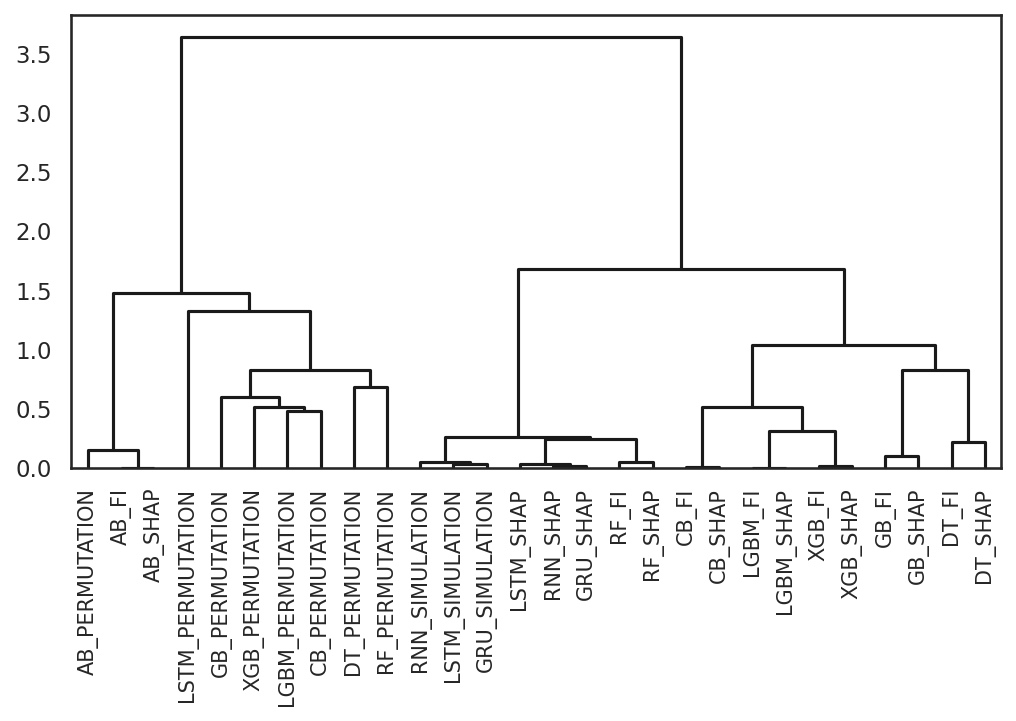

In [59]:
# 3. Clustering
# option = 'complete', 'average', 'ward'

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
linkage = linkage(squareform(dissimilarity), 'ward') 

# 3. Dendrogram
from scipy.cluster.hierarchy import dendrogram

label = score_rank_df.columns[3:]
plt.figure(figsize = (8, 4), dpi=150)
dendrogram(linkage, labels = label, orientation='top', leaf_rotation=90, color_threshold=0, above_threshold_color='k');

## Revised version 230313
- Correlation for the top 20 items of each of the 27 methodologies excluding lstm_permutation
- As a result of the union, 98 items were selected

In [53]:
# List containing the union of top 20 itemids for 27 methodologies (98 items)

df = pd.read_csv('score_rank_df.csv')
df = df.drop(['LSTM_per'], axis=1)

top20_union = []
for i in df.columns[3:]:
    lst = df[['feature', 'feature_name', i]].sort_values(by=i).iloc[:20]['feature'].values
    for j in lst:
        if j not in top20_union:
            top20_union.append(j)

# Union result df for 98 features based on 27 methodologies
df_union = df[df['feature'].isin(top20_union)]
df_union

,feature,feature_name,type,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap
0,0,D5W,PRE,17.0,10.0,9.0,33.0,25.5,141.0,32.0,20.0,44.0,63.0,23.0,13.0,3592.0,16.0,20.0,11.0,18.0,5.0,3.0,3.0,30.0,18.0,88.0,31.0,43.0,32.0,38.0
2,50804,Calculated Total CO2,LAB,26.0,93.0,38.0,195.0,1822.5,37.0,1947.5,553.0,102.5,153.0,154.5,1819.0,11.0,1844.5,124.0,103.0,109.0,180.0,84.0,123.0,202.0,1822.5,28.0,1949.0,205.0,172.0,160.0
8,50813,Lactate,LAB,30.0,30.0,17.0,9.0,1822.5,13.0,11.0,38.0,3.5,9.0,22.0,1819.0,61.0,14.0,16.0,16.0,23.0,23.0,44.0,21.0,7.0,1822.5,7.0,9.0,10.0,7.0,9.0
10,50818,pCO2,LAB,20.0,271.0,41.0,64.0,1822.5,38.0,190.0,362.0,136.5,54.0,200.0,1819.0,209.0,117.0,32.0,60.0,90.0,51.0,50.0,44.0,83.0,1822.5,35.0,124.0,84.0,96.0,45.0
11,50820,pH,LAB,23.0,40.0,21.0,68.0,1822.5,49.0,1947.5,537.0,136.5,2323.5,133.0,1819.0,3558.0,1844.5,3576.0,204.0,1899.0,18.0,43.0,16.0,74.0,1822.5,71.0,1949.0,180.0,190.0,2323.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,60505083404,CefePIME,PRE,355.0,463.0,332.0,245.0,25.5,278.0,114.0,240.0,81.0,110.0,3498.0,3594.0,3581.0,3567.0,3552.0,3588.0,3590.0,794.0,497.0,628.0,158.0,35.0,219.0,120.0,76.0,75.0,88.0
3351,62856024541,Donepezil,PRE,161.0,127.0,158.0,2110.5,25.5,516.0,61.0,73.0,102.5,69.0,1852.0,24.0,309.0,48.0,19.0,74.0,29.0,259.0,259.0,247.0,606.0,42.0,604.0,69.0,115.0,112.0,93.0
3392,63323026201,Heparin,PRE,4.0,4.0,4.0,2.0,25.5,4.0,2.0,2.0,8.0,3.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,5.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0
3399,63323030201,Vasopressin,PRE,232.0,190.0,189.0,17.0,25.5,240.0,34.0,39.0,44.0,25.0,3512.0,18.0,86.0,38.0,90.0,129.0,41.0,482.0,441.0,410.0,17.0,14.0,94.0,27.0,37.0,27.0,33.0


In [50]:
df_union.columns

Index(['feature', 'feature_name', 'type', 'RNN_FI', 'LSTM_FI', 'GRU_FI',
       'DT_FI', 'AB_FI', 'RF_FI', 'GB_FI', 'XGB_FI', 'LGBM_FI', 'CB_FI',
       'DT_per', 'AB_per', 'RF_per', 'GB_per', 'XGB_per', 'LGBM_per', 'CB_per',
       'RNN_shap', 'LSTM_shap', 'GRU_shap', 'DT_shap', 'AB_shap', 'RF_shap',
       'GB_shap', 'XGB_shap', 'LGBM_shap', 'CB_shap'],
      dtype='object')

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


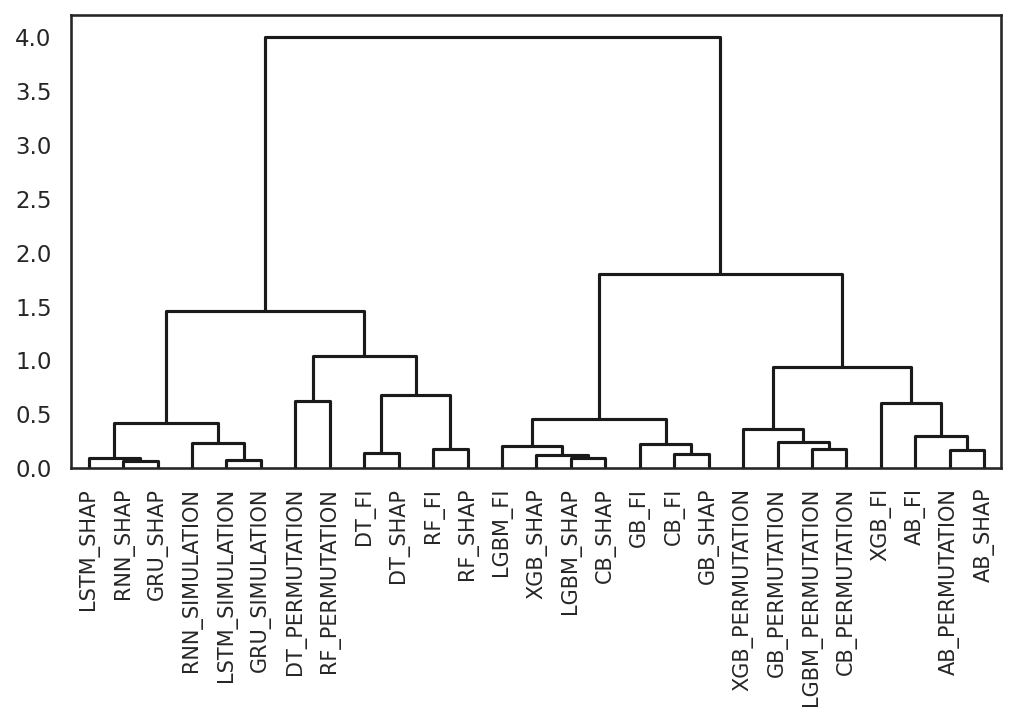

In [83]:
# 1. data (27, 98)
data = []
for i in df_union.columns[3:]:
    data.append(df_union[i].values)
data = np.array(data)
data
data.shape

# 2. dissimilarity
from scipy import stats
from itertools import combinations

dissimilarity = []
idx_pair_lst = list(combinations(range(27), 2))
for i in idx_pair_lst:
    dissimilarity.append((1 - stats.spearmanr(data[i[0]], data[i[1]])[0]) * 0.5)

len(dissimilarity)

# 3. Clustering
# option = 'complete', 'average', 'ward'

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
linkage = linkage(squareform(dissimilarity), 'ward') 

# 4. Dendrogram
from scipy.cluster.hierarchy import dendrogram

label = ['RNN_SIMULATION', 'LSTM_SIMULATION', 'GRU_SIMULATION', 'DT_FI', 'AB_FI', 'RF_FI', 'GB_FI',
       'XGB_FI', 'LGBM_FI', 'CB_FI', 'DT_PERMUTATION', 'AB_PERMUTATION', 'RF_PERMUTATION', 'GB_PERMUTATION',
       'XGB_PERMUTATION', 'LGBM_PERMUTATION', 'CB_PERMUTATION', 'RNN_SHAP', 'LSTM_SHAP', 'GRU_SHAP',
       'DT_SHAP', 'AB_SHAP', 'RF_SHAP', 'GB_SHAP', 'XGB_SHAP', 'LGBM_SHAP',
       'CB_SHAP']
plt.figure(figsize = (8, 4), dpi=150)
dendrogram(linkage, labels = label, orientation='top', leaf_rotation=90, color_threshold=0, above_threshold_color='k');

,RNN_FI,LSTM_FI,GRU_FI,DT_FI,AB_FI,RF_FI,GB_FI,XGB_FI,LGBM_FI,CB_FI,DT_per,AB_per,RF_per,GB_per,XGB_per,LGBM_per,CB_per,RNN_shap,LSTM_shap,GRU_shap,DT_shap,AB_shap,RF_shap,GB_shap,XGB_shap,LGBM_shap,CB_shap
0,17.0,10.0,9.0,33.0,25.5,141.0,32.0,20.0,44.0,63.0,23.0,13.0,3592.0,16.0,20.0,11.0,18.0,5.0,3.0,3.0,30.0,18.0,88.0,31.0,43.0,32.0,38.0
2,26.0,93.0,38.0,195.0,1822.5,37.0,1947.5,553.0,102.5,153.0,154.5,1819.0,11.0,1844.5,124.0,103.0,109.0,180.0,84.0,123.0,202.0,1822.5,28.0,1949.0,205.0,172.0,160.0
8,30.0,30.0,17.0,9.0,1822.5,13.0,11.0,38.0,3.5,9.0,22.0,1819.0,61.0,14.0,16.0,16.0,23.0,23.0,44.0,21.0,7.0,1822.5,7.0,9.0,10.0,7.0,9.0
10,20.0,271.0,41.0,64.0,1822.5,38.0,190.0,362.0,136.5,54.0,200.0,1819.0,209.0,117.0,32.0,60.0,90.0,51.0,50.0,44.0,83.0,1822.5,35.0,124.0,84.0,96.0,45.0
11,23.0,40.0,21.0,68.0,1822.5,49.0,1947.5,537.0,136.5,2323.5,133.0,1819.0,3558.0,1844.5,3576.0,204.0,1899.0,18.0,43.0,16.0,74.0,1822.5,71.0,1949.0,180.0,190.0,2323.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,355.0,463.0,332.0,245.0,25.5,278.0,114.0,240.0,81.0,110.0,3498.0,3594.0,3581.0,3567.0,3552.0,3588.0,3590.0,794.0,497.0,628.0,158.0,35.0,219.0,120.0,76.0,75.0,88.0
3351,161.0,127.0,158.0,2110.5,25.5,516.0,61.0,73.0,102.5,69.0,1852.0,24.0,309.0,48.0,19.0,74.0,29.0,259.0,259.0,247.0,606.0,42.0,604.0,69.0,115.0,112.0,93.0
3392,4.0,4.0,4.0,2.0,25.5,4.0,2.0,2.0,8.0,3.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,5.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0
3399,232.0,190.0,189.0,17.0,25.5,240.0,34.0,39.0,44.0,25.0,3512.0,18.0,86.0,38.0,90.0,129.0,41.0,482.0,441.0,410.0,17.0,14.0,94.0,27.0,37.0,27.0,33.0


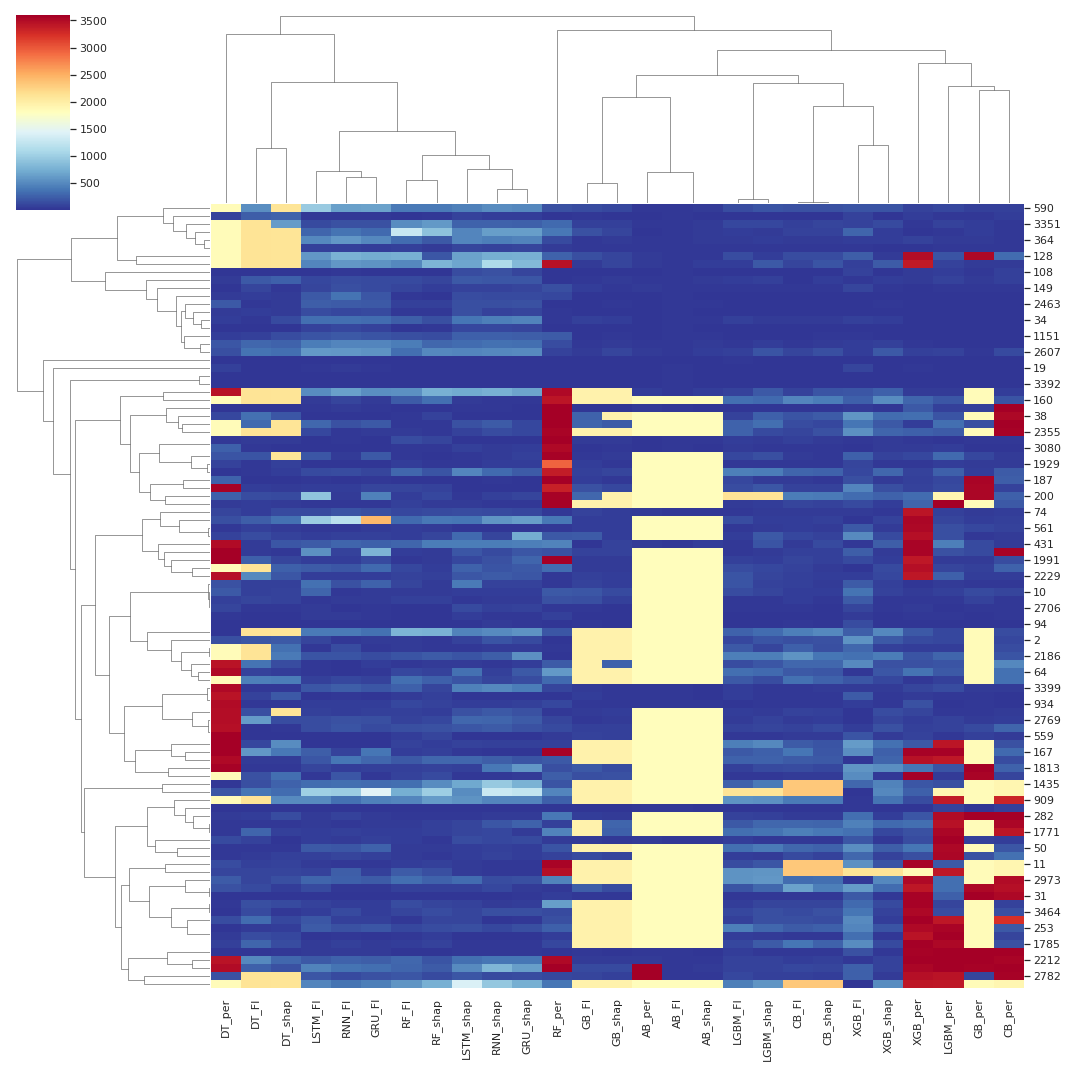

In [71]:
# 5. sns.clustermap 
data2 = df_union.iloc[:,3:]
data2
sns.clustermap(data2, cmap = 'RdYlBu_r', metric="correlation", figsize=(15,15))

# Visualization

In [7]:
# 0. Create a dict containing information for 4069 types of feature names
feature_df = pd.read_csv('feature_df.csv')
feature_name = dict(zip(feature_df['feature'], feature_df['feature_name']))

X = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# 1. Index of deceased / survived patients
d_index = np.where(y==1)[0]
s_index = np.where(y==0)[0]

# 2. Separate deceased / survived patients
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []

for d in range(10):
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def absum(top10_list):
    plt.figure(figsize = (17,6), dpi=300)
    i = 0
    for f in top10_list:
        if f == 0:
            continue
        plt.subplot(2,5,1+i)
        plt.title(feature_name[f])
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='death')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='recovery', linestyle=':', marker='o')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
        i += 1
    plt.tight_layout()

((40680, 3), (40680, 3))